In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class CustomCityScapeDS(Dataset):
    def __init__(self, root = None, split = "train", mode = "fine", 
                 transform = None, sematic_transform = None):
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        self.target_transform = {}

        self.semantic_map = {
            0 : ['unlabeled', 19, 'void'], 
            1 : ['ego vehicle', 19, 'void'],
            2 : ['rectification border', 19, 'void'],
            3 : ['out of roi', 19, 'void'],
            4 : ['static', 19, 'void'],
            5 : ['dynamic', 19, 'void'],
            6 : ['ground', 19, 'void'],
            7 : ['road', 0, 'flat'],
            8 : ['sidewalk', 1, 'flat'],
            9 : ['parking', 19, 'flat'],
            10 : ['rail track', 19, 'flat'],
            11 : ['building', 2, 'construction'],
            12 : ['wall', 3, 'construction'],
            13 : ['fence', 4, 'construction'],
            14 : ['guard rail', 19, 'construction'],
            15 : ['bridge', 19, 'construction'],
            16 : ['tunnel', 19, 'construction'],
            17 : ['pole', 5, 'object'],
            18 : ['polegroup', 19, 'object'],
            19 : ['traffic light', 6, 'object'],
            20 : ['traffic sign', 7, 'object'],
            21 : ['vegetation', 8, 'nature'],
            22 : ['terrain', 9, 'nature'],
            23 : ['sky', 10, 'sky'],
            24 : ['person', 11, 'human'],
            25 : ['rider', 12, 'human'],
            26 : ['car', 13, 'vehicle'],
            27 : ['truck', 14, 'vehicle'],
            28 : ['bus', 15, 'vehicle'],
            29 : ['caravan', 19, 'vehicle'],
            30 : ['trailer', 19, 'vehicle'],
            31 : ['train', 16, 'vehicle'],
            32 : ['motorcycle', 17, 'vehicle'],
            33 : ['bicycle', 18, 'vehicle'],
            34 : ['license plate', -1, 'vehicle']
        }
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((256, 512)), transforms.ToTensor()])
        
        if sematic_transform:
            self.target_transform['semantic'] = sematic_transform
        else:
            self.target_transform['semantic'] = transforms.Compose(
                [transforms.Resize((256, 512)), transforms.PILToTensor(), self.make_semantic_class])

        self.root = "/media/mountHDD2/cityscapes" if not root else root

        if self.mode == "fine":
            if self.split not in ['train', 'val', 'test']:
                raise ValueError("self.split has to be one of ['train', 'val', 'test']")
        elif self.mode == "coarse":
            if self.split not in ['train', 'train_extra', 'val']:
                raise ValueError("self.split has to be one of ['train', 'train_extra', 'val']")
        else:
            raise Value_colorError(f"mode cannot be {self.mode}")

        self.img_dir = self.root + f"/leftImg8bit/{self.split}"
        self.mode_folder = "gtFine" if self.mode == "fine" else "gtCoarse"
        self.semantic_dir = self.root + f"/{self.mode_folder}/{self.split}"
        self.depth_dir = self.root + f"/disparity/{self.split}"

        for check_dir in [self.img_dir, self.semantic_dir, self.depth_dir]:
            if not os.path.exists(check_dir):
                print(f"The dataset source is not available or not extracted at {self.root}")

        print("Data Set Setting Up")
        for city in tqdm(os.listdir(self.img_dir)):
            img_dir = os.path.join(self.img_dir, city)
            semantic_target_dir = os.path.join(self.semantic_dir, city)
            depth_target_dir = os.path.join(self.depth_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))

                fn = file_name.split("_leftImg8bit")[0]
                mode_folder = semantic_target_dir.split("/")[-3]

                self.targets.append(
                    {
                        "semantic" : os.path.join(semantic_target_dir, f"{fn}_{mode_folder}_labelIds.png"),
                        "depth" : os.path.join(depth_target_dir, f"{fn}_disparity.png"),
                    }
                )
                
        print("Done")
    
    def make_semantic_class(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in self.semantic_map:
            encx[x == label] = self.semantic_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

    def process_depth(self, x):
        depth = cv2.imread(x, cv2.IMREAD_UNCHANGED).astype(np.float32)
        depth = cv2.resize(depth, (512, 256))
        depth[depth > 0] = (depth[depth > 0] - 1) / 256
        
        # depth = 0.209313 * 2262.52 / depth

        depth[depth == np.inf] = 0
        depth[depth == np.nan] = 0
        depth[depth < 0] = 0

        # depth = np.minimum(depth, 100) 

        torch_depth = torch.from_numpy(depth).unsqueeze(0) / 255.0

        return torch_depth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.images[idx]).convert("RGB"))

        target = {}
        target['semantic'] = self.target_transform['semantic'](Image.open(self.targets[idx]['semantic']))
        target['depth'] = self.process_depth(self.targets[idx]['depth'])

        return img, target

In [3]:
train_fine_ds = CustomCityScapeDS(split = 'train', mode = 'fine')
valid_fine_ds = CustomCityScapeDS(split = 'val', mode = 'fine')
test_fine_ds = CustomCityScapeDS(split = 'test', mode = 'fine')

print(len(train_fine_ds))
print(len(valid_fine_ds))
print(len(test_fine_ds))

Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1951.90it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1690.34it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1248.37it/s]

Done
2975
500
1525


In [4]:
train_fine_dl = DataLoader(train_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_fine_dl = DataLoader(valid_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_fine_dl = DataLoader(test_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Batch: {}".format(len(train_fine_dl)))
print("#Validation Batch: {}".format(len(valid_fine_dl)))
print("#Testing Batch: {}".format(len(test_fine_dl)))

#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
semantic_target shape: torch.Size([19, 256, 512])
depth_target shape: torch.Size([1, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])


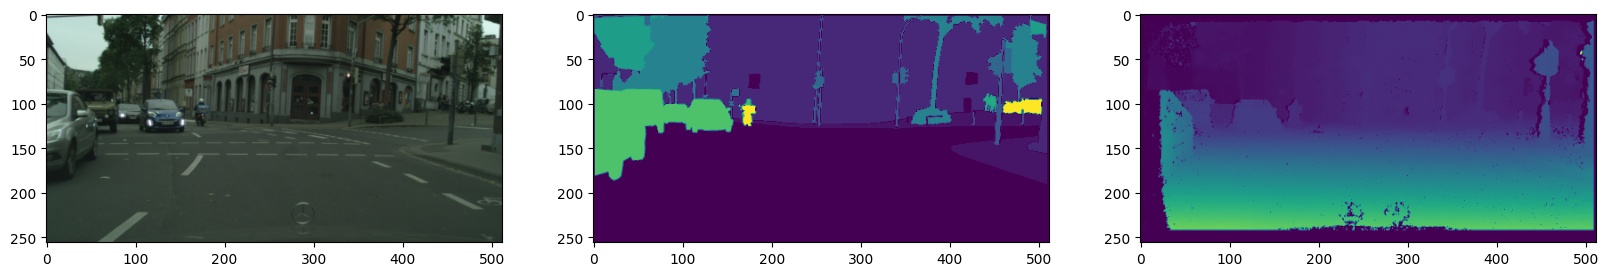

In [5]:
for idx in range(1):
    data, target = train_fine_ds[idx]

    semantic_target = target['semantic']
    depth_target = target['depth']
    
    print(f"data shape: {data.shape}")
    print(f"semantic_target shape: {semantic_target.shape}")
    print(f"depth_target shape: {depth_target.shape}")
    
    num_class = semantic_target.shape[0]
    print(f"Number classes: {num_class}")
    print(f"Classes: {torch.unique(torch.argmax(semantic_target, dim = 0))}")
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(data.permute(1, -1, 0).numpy())
    axarr[1].imshow(torch.argmax(semantic_target, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())
    axarr[2].imshow(depth_target.permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Pyramid(nn.Module):
    def __init__(self, n_channels=3):
        super(Pyramid, self).__init__()
        self.n_channels = n_channels

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        self.down4 = (Down(256, 512)) #512, 1024

        self.toplayer = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0),
            # nn.Upsample(scale_factor=2, mode='bilinear')
        )

        self.latlayer1 = nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        self.smooth1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        # Depth prediction
        self.predict1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.predict2 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.up = nn.Upsample(scale_factor=2, mode='bilinear')

    def _upsample_add(self, x, y):
        _,_,H,W = y.size()
        return F.interpolate(x, size=(H,W), mode='bilinear') + y
        
    def forward(self, x):
        d1 = self.inc(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)

        u5 = self.toplayer(d5)
        
        u4 = self._upsample_add(u5, self.latlayer1(d4))
        u4 = self.smooth1(u4)
        u3 = self._upsample_add(u4, self.latlayer2(d3))
        u3 = self.smooth2(u3)
        u2 = self._upsample_add(u3, self.latlayer3(d2))
        u2 = self.smooth2(u2)

        u1 = self.up(u2)

        return self.predict2(self.predict1(u1))

In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x_pred, x_output):
        binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1)
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

        return loss

In [10]:
def depth_error(x_pred, x_output):
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = torch.abs(x_pred_true - x_output_true) / x_output_true
    return (
        torch.sum(abs_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    ).item(), (
        torch.sum(rel_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)
    ).item()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = Pyramid().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = CustomLoss()

In [12]:
for epoch in range(10):
    total_train_loss = 0
    total_train_abs_err = 0
    total_train_rel_err = 0
    model.train()
    for i, (train_img, train_depth) in tqdm(enumerate(train_fine_dl)):
        train_img, train_depth = train_img.to(device), train_depth['depth'].to(device)
        
        train_depth_fake = model(train_img)
        
        train_loss = loss_fn(train_depth_fake, train_depth)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        train_abs_err, train_rel_err = depth_error(train_depth_fake, train_depth)
        total_train_abs_err += train_abs_err
        total_train_rel_err += train_rel_err
        
    with torch.no_grad():
        model.eval()
        total_valid_loss = 0
        total_valid_abs_err = 0
        total_valid_rel_err = 0
        for i, (valid_img, valid_depth) in tqdm(enumerate(valid_fine_dl)):
            valid_img, valid_depth = valid_img.to(device), valid_depth['depth'].to(device)
            
            valid_depth_fake = model(valid_img)
            
            valid_loss = loss_fn(valid_depth_fake, valid_depth)
            total_valid_loss += valid_loss.item()

            valid_abs_err, valid_rel_err = depth_error(train_depth_fake, train_depth)
            total_valid_abs_err += valid_abs_err
            total_valid_rel_err += valid_rel_err

    print(f"Epoch: {epoch} - Train Loss: {total_train_loss/len(train_fine_dl)} - Valid Loss: {total_valid_loss/len(valid_fine_dl)}")
    print(f"Epoch: {epoch} - Tr_Abs_Err: {total_train_abs_err/len(train_fine_dl)} - Va_Abs_Err: {total_valid_abs_err/len(valid_fine_dl)}")
    print(f"Epoch: {epoch} - Tr_Rel_Err: {total_train_rel_err/len(train_fine_dl)} - Va_Rel_Err: {total_valid_rel_err/len(valid_fine_dl)}")

93it [00:38,  2.42it/s]
16it [00:06,  2.55it/s]

Epoch: 0 - Train Loss: 0.14118171331062113 - Valid Loss: 0.1381419338285923
Epoch: 0 - Tr_Abs_Err: 0.14118171331062113 - Va_Abs_Err: 0.14093483984470367
Epoch: 0 - Tr_Rel_Err: 1.1950482206959878 - Va_Rel_Err: 1.0



93it [00:29,  3.13it/s]
16it [00:06,  2.58it/s]

Epoch: 1 - Train Loss: 0.13813820449254846 - Valid Loss: 0.13815961126238108
Epoch: 1 - Tr_Abs_Err: 0.13813820593459633 - Va_Abs_Err: 0.13605989515781403
Epoch: 1 - Tr_Rel_Err: 0.9999999878227069 - Va_Rel_Err: 1.0



93it [00:29,  3.20it/s]
16it [00:06,  2.63it/s]

Epoch: 2 - Train Loss: 0.13813980692817318 - Valid Loss: 0.13819092977792025
Epoch: 2 - Tr_Abs_Err: 0.1381398061270355 - Va_Abs_Err: 0.13738729059696198
Epoch: 2 - Tr_Rel_Err: 0.999999983977246 - Va_Rel_Err: 0.9999999403953552



93it [00:28,  3.24it/s]
16it [00:06,  2.60it/s]

Epoch: 3 - Train Loss: 0.13813482465282564 - Valid Loss: 0.13825022988021374
Epoch: 3 - Tr_Abs_Err: 0.13813482353123285 - Va_Abs_Err: 0.13692961633205414
Epoch: 3 - Tr_Rel_Err: 0.9999999858999765 - Va_Rel_Err: 1.0



93it [00:28,  3.26it/s]
16it [00:06,  2.53it/s]

Epoch: 4 - Train Loss: 0.1381404427110508 - Valid Loss: 0.13823174312710762
Epoch: 4 - Tr_Abs_Err: 0.13814044399287112 - Va_Abs_Err: 0.13504238426685333
Epoch: 4 - Tr_Rel_Err: 0.9999999923090781 - Va_Rel_Err: 1.0



93it [00:28,  3.23it/s]
16it [00:06,  2.58it/s]

Epoch: 5 - Train Loss: 0.138137516795948 - Valid Loss: 0.13813142757862806
Epoch: 5 - Tr_Abs_Err: 0.13813751663572044 - Va_Abs_Err: 0.1361219584941864
Epoch: 5 - Tr_Rel_Err: 0.9999999871817968 - Va_Rel_Err: 1.0



93it [00:29,  3.17it/s]
16it [00:06,  2.55it/s]

Epoch: 6 - Train Loss: 0.1381402103811182 - Valid Loss: 0.1381834102794528
Epoch: 6 - Tr_Abs_Err: 0.13814020990043557 - Va_Abs_Err: 0.13854487240314484
Epoch: 6 - Tr_Rel_Err: 0.9999999910272578 - Va_Rel_Err: 1.0



93it [00:29,  3.19it/s]
16it [00:06,  2.47it/s]

Epoch: 7 - Train Loss: 0.13813467275711797 - Valid Loss: 0.13812184892594814
Epoch: 7 - Tr_Abs_Err: 0.13813467195598028 - Va_Abs_Err: 0.13377590477466583
Epoch: 7 - Tr_Rel_Err: 0.9999999897454375 - Va_Rel_Err: 1.0



93it [00:29,  3.13it/s]
16it [00:06,  2.51it/s]

Epoch: 8 - Train Loss: 0.13813810146624042 - Valid Loss: 0.1382034234702587
Epoch: 8 - Tr_Abs_Err: 0.13813810210715058 - Va_Abs_Err: 0.1410699039697647
Epoch: 8 - Tr_Rel_Err: 0.9999999833363359 - Va_Rel_Err: 1.0



93it [00:29,  3.12it/s]
16it [00:06,  2.57it/s]

Epoch: 9 - Train Loss: 0.13813996090683886 - Valid Loss: 0.1382093783468008
Epoch: 9 - Tr_Abs_Err: 0.13813996122729394 - Va_Abs_Err: 0.1345241367816925
Epoch: 9 - Tr_Rel_Err: 0.9999999884636172 - Va_Rel_Err: 1.0


In [15]:
with torch.no_grad():
    model.eval()
    total_test_loss = 0
    for i, (test_img, test_depth) in tqdm(enumerate(test_fine_dl)):
        test_img, test_depth = test_img.to(device), test_depth['depth'].to(device)
        
        test_depth_fake = model(test_img)        
        
        test_loss = loss_fn(test_depth_fake, test_depth)
        total_test_loss += test_loss.item()
print(f"Test Loss: {total_test_loss/len(test_fine_dl)}")

48it [00:12,  3.80it/s]

Test Loss: 0.13592539044717947


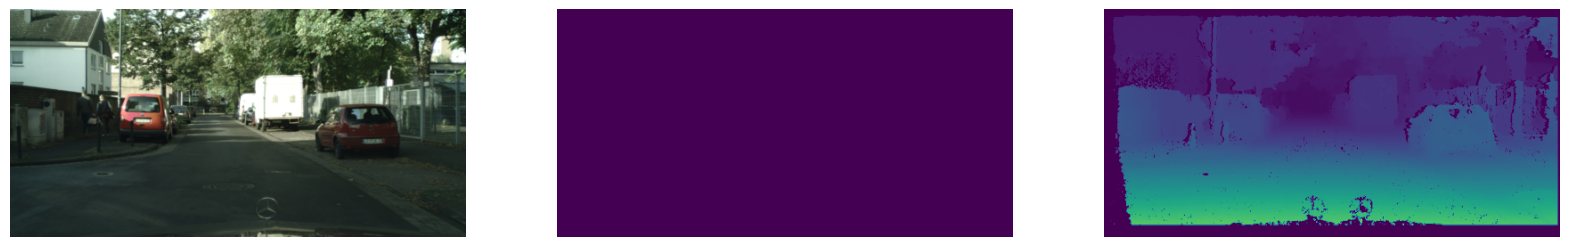

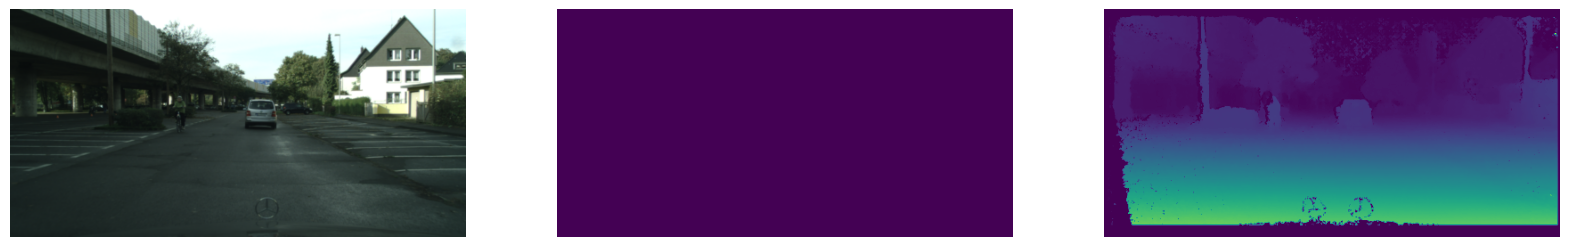

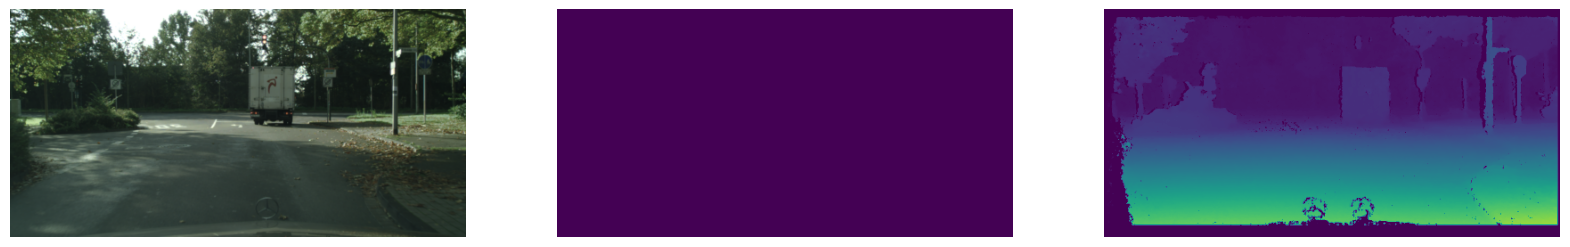

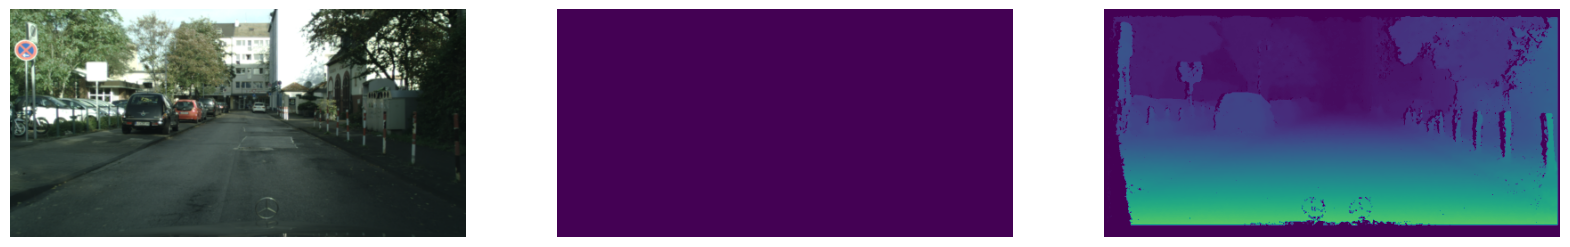

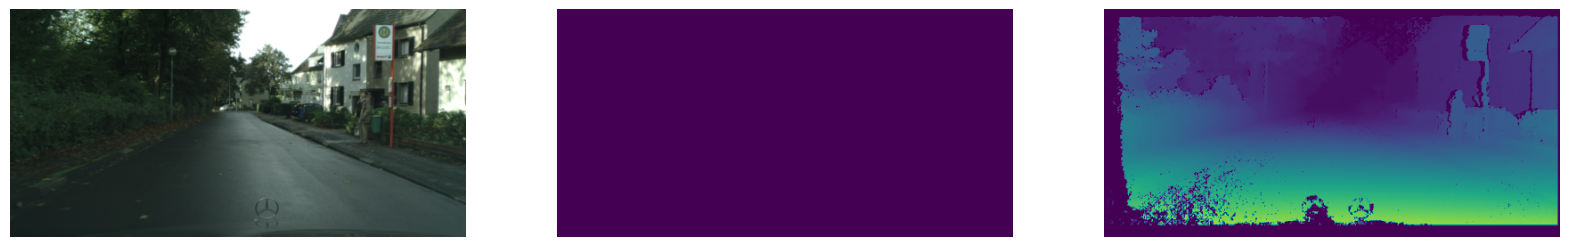

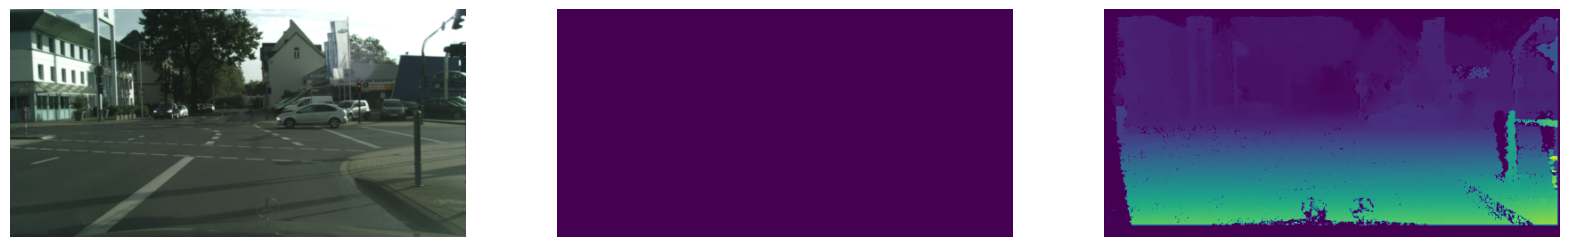

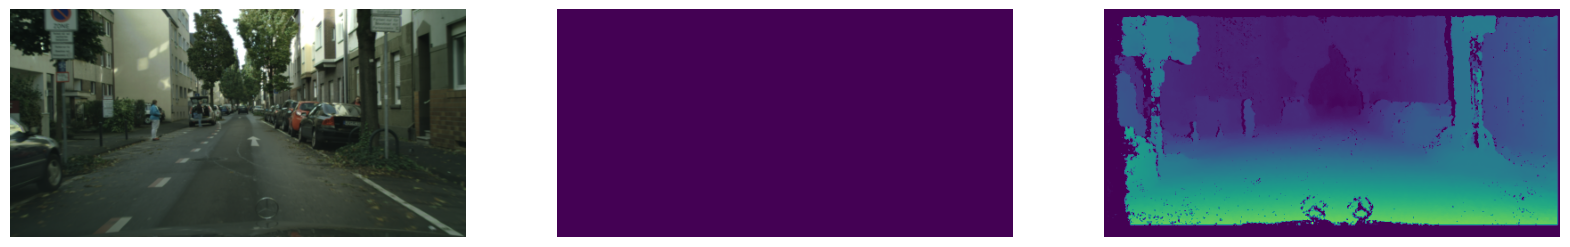

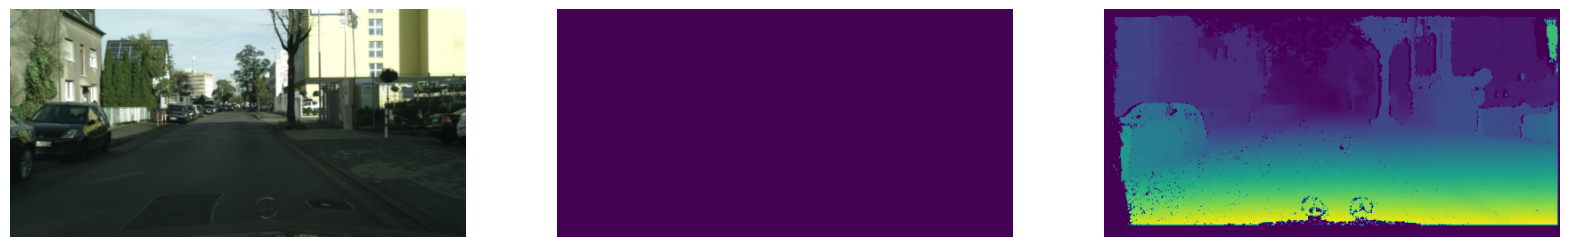

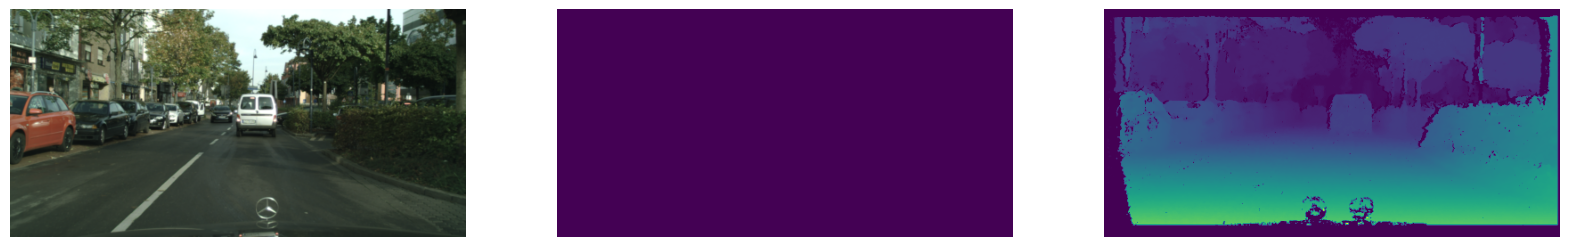

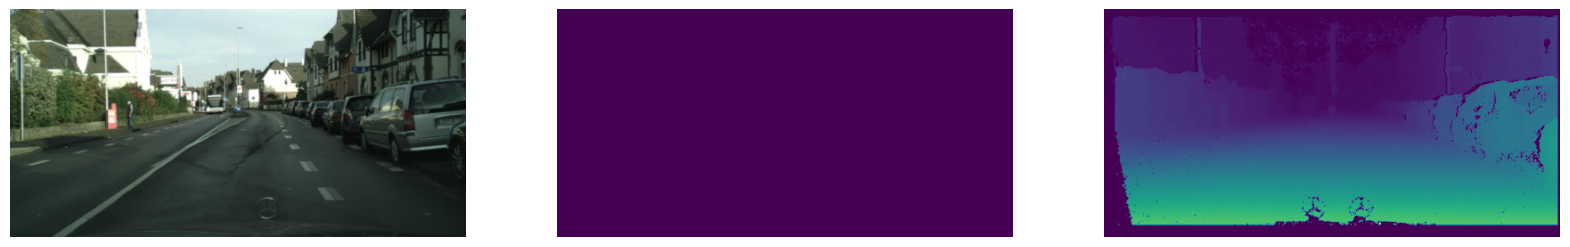

In [16]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        test_img, test_depth = test_fine_ds[test_case_idx]
        test_img = test_img.unsqueeze(dim=0).to(device)
        test_depth = test_depth['depth']

        test_depth_fake = model(test_img)     
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(test_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(test_depth_fake[0].permute(1, -1, 0).cpu().numpy())
        axarr[1].axis('off')
        axarr[2].imshow(test_depth.permute(1, -1, 0).cpu().numpy())
        axarr[2].axis('off')